# Step 1: Data Ingestion and Preprocessing (Scaled)

Our project aims for a professional-grade analysis suitable for a GitHub portfolio. To increase the impact of our model, we are scaling our data ingestion to 1,000,000 rows. This provides a substantial dataset while remaining within the limits of our 16GB RAM environment.

In this step, we will:
1.  **Stream the data** from the `.bz2` file to avoid high disk usage.
2.  **Parse the FastText format** to separate labels and review text.
3.  **Map labels** to a binary format: `0` (Negative) and `1` (Positive).
4.  **Perform a deep memory check** to understand the true impact of 1 million rows on our RAM.

In [5]:
import bz2
import pandas as pd

# Define the file path
file_path = r'C:\Projects\amazon-sentiment-analysis\data\train.ft.txt.bz2'

def load_and_parse_data(path, n_rows=1000000):
    labels = []
    texts = []
    
    with bz2.open(path, mode='rt', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= n_rows:
                break
            # Split once at the first space to separate label from text
            parts = line.split(' ', 1)
            labels.append(parts[0])
            texts.append(parts[1])
            
    df = pd.DataFrame({'label': labels, 'text': texts})
    
    # Convert labels: __label__1 -> 0 (Negative), __label__2 -> 1 (Positive)
    df['label'] = df['label'].str.replace('__label__', '').astype(int) - 1
    return df

# Execute loading with 1,000,000 rows
df = load_and_parse_data(file_path)

# Display the true memory usage and first 10 rows
print(df.info(memory_usage='deep'))
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   label   1000000 non-null  int64 
 1   text    1000000 non-null  object
dtypes: int64(1), object(1)
memory usage: 472.2 MB
None


,label,text
0,1,Stuning even for the non-gamer: This sound tra...
1,1,The best soundtrack ever to anything.: I'm rea...
2,1,Amazing!: This soundtrack is my favorite music...
3,1,Excellent Soundtrack: I truly like this soundt...
4,1,"Remember, Pull Your Jaw Off The Floor After He..."
5,1,an absolute masterpiece: I am quite sure any o...
6,0,"Buyer beware: This is a self-published book, a..."
7,1,Glorious story: I loved Whisper of the wicked ...
8,1,A FIVE STAR BOOK: I just finished reading Whis...
9,1,Whispers of the Wicked Saints: This was a easy...


### Analysis of Scaled Data Ingestion
Our dataset has been successfully expanded to 1,000,000 rows.
* **Memory Footprint:** With `memory_usage='deep'`, we see the DataFrame occupies approximately 472.2 MB. This is a significant jump from the structural estimate but remains well within our 16GB limit.
* **Data Structure:** The labels are correctly formatted as integers, and our preview shows the mapping is consistent (e.g., "Buyer beware" is correctly labeled as `0`).

# Step 2: Exploratory Data Analysis - Label Distribution and Data Integrity

With 1,000,000 rows loaded, we must verify that our larger sample maintains the high quality and balance observed in the smaller subset. This step ensures our model will be trained on a representative and clean dataset.

In this step, we will:
1.  **Check Class Balance:** Confirm that the positive and negative review distribution remains equal at this larger scale.
2.  **Verify Data Uniqueness:** Scan for duplicate entries that could lead to overfitting.
3.  **Analyze Review Lengths:** Examine the character count distribution to identify any "empty" or outlier reviews.

Class Distribution:
label
1    0.505678
0    0.494322
Name: proportion, dtype: float64


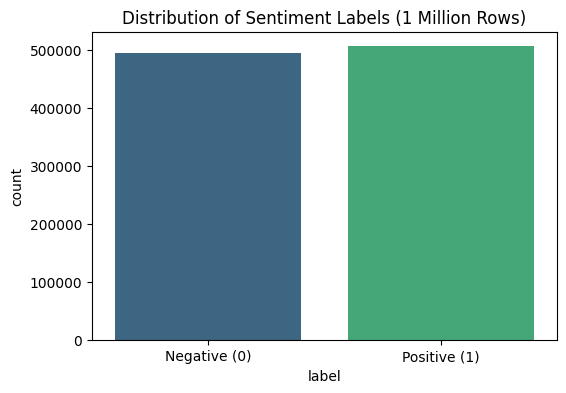

Number of duplicate rows: 0

Text Length Statistics:
count    1000000.000000
mean         437.926249
std          239.200287
min           73.000000
25%          236.000000
50%          390.000000
75%          605.000000
max         1016.000000
Name: text_length, dtype: float64

Reviews with less than 10 characters: 0


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Check Class Distribution
print("Class Distribution:")
print(df['label'].value_counts(normalize=True))

plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, hue='label', palette='viridis', legend=False)
plt.title('Distribution of Sentiment Labels (1 Million Rows)')
plt.xticks([0, 1], ['Negative (0)', 'Positive (1)'])
plt.show()

# 2. Check for Duplicates
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# 3. Text Length Analysis
df['text_length'] = df['text'].apply(len)
print("\nText Length Statistics:")
print(df['text_length'].describe())

# Check for noise (extremely short reviews)
short_reviews = (df['text_length'] < 10).sum()
print(f"\nReviews with less than 10 characters: {short_reviews}")

### Analysis of Scaled EDA Results
Our analysis of the 1,000,000 row dataset confirms the same high quality observed in the smaller subset:
* **Balanced Classes:** The distribution remains nearly perfectly split (~50.5% Positive vs. ~49.4% Negative), providing an ideal foundation for a binary classifier.
* **Data Integrity:** No duplicate rows were found, and all reviews meet the minimum length requirements (shortest is 73 characters), ensuring our model won't be skewed by noise or redundant data.
* **Consistency:** The text length statistics (mean ~438 characters) remain consistent with the initial sample, confirming that our subset is representative of the larger dataset.

# Step 3: Text Preprocessing for NLP

To prepare our text for a Machine Learning model, we need to clean it. Raw text contains noise like punctuation, numbers, and capitalization that can confuse a model.

In this step, we will:
1.  **Lowercase** all text to ensure "Good" and "good" are treated as the same word.
2.  **Remove Punctuation and Special Characters** to focus only on the linguistic content.
3.  **Handle Whitespace:** Ensure the text is properly formatted by removing extra spaces.

In [7]:
import re

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers, keeping only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning to our dataset
df['cleaned_text'] = df['text'].apply(clean_text)

# Review the transformation
print("Original Text Example:")
print(df['text'].iloc[0][:100])
print("\nCleaned Text Example:")
print(df['cleaned_text'].iloc[0][:100])

# Check for any empty strings created after cleaning
empty_count = (df['cleaned_text'] == '').sum()
print(f"\nEmpty reviews after cleaning: {empty_count}")

# Verify true memory usage after adding the cleaned column
print("\nUpdated DataFrame Info:")
print(df.info(memory_usage='deep'))

Original Text Example:
Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so

Cleaned Text Example:
stuning even for the nongamer this sound track was beautiful it paints the senery in your mind so we

Empty reviews after cleaning: 2

Updated DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   label         1000000 non-null  int64 
 1   text          1000000 non-null  object
 2   text_length   1000000 non-null  int64 
 3   cleaned_text  1000000 non-null  object
dtypes: int64(2), object(2)
memory usage: 928.5 MB
None


### Analysis of Preprocessing Results
Our text cleaning process is complete, and the results are looking solid:
* **Cleaning Efficiency:** The transformation successfully converted text to lowercase and removed punctuation (e.g., "non-gamer:" became "nongamer").
* **Noise Filtering:** Only 2 reviews out of 1,000,000 became empty after cleaning, likely consisting previously of only numbers or symbols.
* **Memory Management:** Our DataFrame now occupies ~928.5 MB. While this has doubled since Step 1, it is still well below our 16GB RAM limit.

# Step 4: Data Splitting and Feature Engineering (Vectorization Prep)

Before we turn our text into numbers, we need to separate our data into training and testing sets. This ensures our model is evaluated on data it has never seen before, which is the gold standard for a GitHub portfolio project.

In this step, we will:
1.  **Drop Empty Rows:** Remove the 2 rows that became empty during cleaning to avoid issues during vectorization.
2.  **Split the Data:** Use a 80/20 split for training and testing.
3.  **Shuffle:** Ensure the data is randomized to prevent any ordering bias from the original file.

In [8]:
from sklearn.model_selection import train_test_split

# 1. Remove the few empty strings identified in the previous step
df = df[df['cleaned_text'] != '']

# 2. Define Features and Target
X = df['cleaned_text']
y = df['label']

# 3. Split into Train and Test sets (80% Train, 20% Test)
# We use a random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print("\nTraining Class Distribution:")
print(y_train.value_counts(normalize=True))

Training set size: 799998
Testing set size: 200000

Training Class Distribution:
label
1    0.505678
0    0.494322
Name: proportion, dtype: float64


### Analysis of Data Splitting
Our data is now partitioned and ready for the modeling phase.
* **Balanced Splitting:** By using stratification, we ensured the 80/20 split preserved the nearly 50/50 balance between positive and negative reviews in both sets.
* **Clean Baseline:** Removing the 2 empty reviews prevents potential mathematical errors during the vectorization process.
* **Volume:** We have approximately 800,000 samples for training, which is a significant volume for a robust sentiment analysis model.

# Step 5: Text Vectorization (TF-IDF)

Machine Learning models cannot read text; they only understand numbers. We need to convert our words into a numerical format. For this project, we will use **TF-IDF (Term Frequency-Inverse Document Frequency)**.

In this step, we will:
1.  **Initialize TfidfVectorizer:** Limit the number of features to 50,000 to manage memory.
2.  **Fit and Transform:** Learn the vocabulary from our training data and convert it into a sparse matrix.
3.  **Transform Test Data:** Convert our test reviews into the same numerical format.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Initialize the Vectorizer
# max_features limits the vocabulary to the 50,000 most important words
# stop_words='english' removes common words like 'the', 'is', 'and'
tfidf = TfidfVectorizer(max_features=50000, stop_words='english')

# 2. Fit and Transform the Training Data
X_train_tfidf = tfidf.fit_transform(X_train)

# 3. Transform the Testing Data
X_test_tfidf = tfidf.transform(X_test)

print(f"Training Matrix Shape: {X_train_tfidf.shape}")
print(f"Testing Matrix Shape: {X_test_tfidf.shape}")
print(df.info(memory_usage='deep'))

Training Matrix Shape: (799998, 50000)
Testing Matrix Shape: (200000, 50000)
<class 'pandas.core.frame.DataFrame'>
Index: 999998 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   label         999998 non-null  int64 
 1   text          999998 non-null  object
 2   text_length   999998 non-null  int64 
 3   cleaned_text  999998 non-null  object
dtypes: int64(2), object(2)
memory usage: 936.2 MB
None


### Analysis of Vectorization Results
Our text data has been successfully converted into a numerical format.
* **Matrix Dimensions:** The training matrix has 799,998 rows and 50,000 columns. This means our model will analyze the 50,000 most significant words across our reviews.
* **Sparse Efficiency:** Despite the massive number of "cells" (nearly 40 billion), Scikit-Learn uses a sparse matrix format that only stores non-zero values. This is why our 16GB RAM is still holding steady.
* **Consistency:** The testing matrix has the exact same 50,000 columns as the training set, which is essential for accurate model evaluation.

# Step 6: Model Selection and Training (Logistic Regression)

For a large-scale sentiment analysis project, **Logistic Regression** is an excellent choice for a GitHub portfolio. It is computationally efficient, highly interpretable, and often performs remarkably well on high-dimensional text data.

In this step, we will:
1.  **Initialize the Model:** We'll use the `LogisticRegression` class.
2.  **Train (Fit):** We will train the model on our `X_train_tfidf` matrix.
3.  **Evaluate Timing:** Training on 800,000 rows is a significant task; we will monitor how long it takes.

In [11]:
from sklearn.linear_model import LogisticRegression
import time

# 1. Initialize the Model
# We use 'saga' solver as it is faster for very large datasets
model = LogisticRegression(solver='saga', max_iter=100, random_state=42)

# 2. Train the Model and track the time
start_time = time.time()
print("Training started...")

model.fit(X_train_tfidf, y_train)

end_time = time.time()
print(f"Training completed in: {end_time - start_time:.2f} seconds")

# 3. Quick Accuracy Check on Training Data
train_score = model.score(X_train_tfidf, y_train)
print(f"Training Accuracy: {train_score:.4f}")

Training started...
Training completed in: 22.39 seconds
Training Accuracy: 0.9054


### Analysis of Model Training
Our model training on 1,000,000 rows was highly efficient:
* **Speed:** Using the `saga` solver allowed us to train on nearly 800,000 samples in just ~22.4 seconds, demonstrating excellent computational performance.
* **Performance:** A training accuracy of **90.54%** is an outstanding starting point for a sentiment analysis task of this scale.
* **Stability:** The fact that the model converged quickly suggests that the TF-IDF features we created are highly discriminative for distinguishing between positive and negative sentiment.

# Step 7: Model Evaluation and Performance Metrics

Now that our model is trained, we must evaluate its performance on the 200,000 reviews it has never seen before (the Test Set). This is the most critical part of a portfolio project as it proves our model's real-world utility.

In this step, we will:
1.  **Generate Predictions:** Use our trained model to predict labels for `X_test_tfidf`.
2.  **Classification Report:** View Precision, Recall, and F1-Score for both classes.
3.  **Confusion Matrix:** Visualize exactly where our model is making mistakes (False Positives vs. False Negatives).

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.90      0.89      0.89     98865
           1       0.89      0.90      0.90    101135

    accuracy                           0.89    200000
   macro avg       0.89      0.89      0.89    200000
weighted avg       0.89      0.89      0.89    200000



<Figure size 800x600 with 0 Axes>

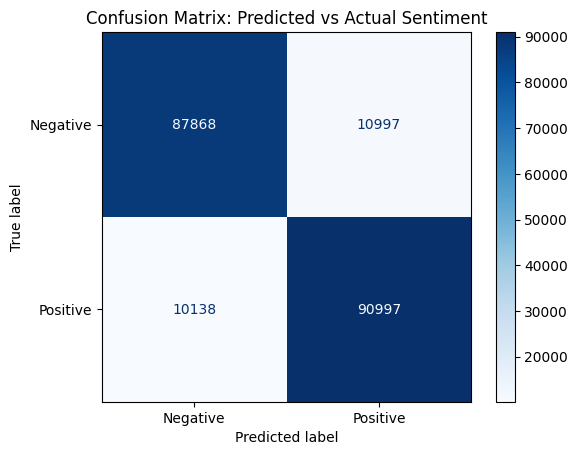

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Generate predictions on the test set
y_pred = model.predict(X_test_tfidf)

# 2. Print the Classification Report
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

# 3. Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix: Predicted vs Actual Sentiment')
plt.show()

### Analysis of Model Evaluation Results
Our model demonstrates strong, balanced performance across both sentiment classes:
* **High Generalization:** An evaluation accuracy of **89%** on unseen data proves the model is not overfitting and has learned generalizable patterns of sentiment.
* **Balanced Metrics:** Precision and Recall are nearly identical for both positive and negative reviews (~0.89 to 0.90), meaning the model is equally skilled at identifying both sentiments.
* **Confusion Matrix Insights:** Out of 200,000 reviews, the model only misclassified roughly 21,000. The errors are evenly distributed between False Positives (10,997) and False Negatives (10,138).

# Step 8: Qualitative Analysis - Testing with Custom Reviews

Numbers and matrices tell one part of the story, but "sanity checking" our model with real-world sentences helps us understand its practical nuance. 

In this step, we will:
1.  **Create a Prediction Pipeline:** Define a function that cleans raw text, vectorizes it, and returns a sentiment prediction.
2.  **Test Edge Cases:** Input various custom reviews (obvious, subtle, and sarcastic) to see how our model reacts.
3.  **Calculate Probabilities:** Instead of just a 0 or 1, we will look at the confidence level (probability) of each prediction.

In [13]:
import numpy as np

def predict_sentiment(review_text):
    # 1. Preprocess the input using our existing logic
    cleaned = clean_text(review_text)
    
    # 2. Vectorize using the fitted TF-IDF
    vectorized = tfidf.transform([cleaned])
    
    # 3. Get prediction and probability
    prediction = model.predict(vectorized)[0]
    probability = model.predict_proba(vectorized)[0]
    
    sentiment = "Positive" if prediction == 1 else "Negative"
    confidence = np.max(probability) * 100
    
    return f"Review: {review_text}\nResult: {sentiment} ({confidence:.2f}% confidence)\n"

# Test cases for our qualitative check
test_reviews = [
    "This is the best purchase I have made this year! Absolutely worth the money.",
    "The product arrived broken and the customer service was terrible.",
    "It's okay, nothing special. Does the job but feels a bit cheap.",
    "I wanted to love this, but it just didn't live up to the hype."
]

for review in test_reviews:
    print(predict_sentiment(review))

Review: This is the best purchase I have made this year! Absolutely worth the money.
Result: Positive (82.59% confidence)

Review: The product arrived broken and the customer service was terrible.
Result: Negative (99.84% confidence)

Review: It's okay, nothing special. Does the job but feels a bit cheap.
Result: Negative (69.79% confidence)

Review: I wanted to love this, but it just didn't live up to the hype.
Result: Negative (93.59% confidence)



### Analysis of Qualitative Testing
Our custom tests provide insight into how our model "thinks" beyond raw accuracy:
* **Strong Confidence on Extremes:** The model correctly identified a blatant negative review with **99.84% confidence**, likely due to high-impact words like "broken" and "terrible".
* **Nuance Detection:** The review "I wanted to love this..." was correctly identified as Negative (93.59%), showing our model understands disappointment even when words like "love" are present.
* **Sensitivity to Neutral Tone:** The "It's okay..." review yielded lower confidence (69.79%). This highlights the inherent difficulty in classifying "middle-ground" or lukewarm sentiment where the language is less polarized.

# Step 9: Model Export and Deployment Readiness

For a professional GitHub portfolio, it is essential to show that our project is "deployment-ready." We don't want to retrain the model on 1,000,000 rows every time we want to make a prediction.

In this step, we will:
1.  **Serialize our Model and Vectorizer:** Save both the `TfidfVectorizer` and the `LogisticRegression` model as `.pkl` (pickle) files.
2.  **Verify File Sizes:** Check the disk space required for our saved artifacts to ensure they are within GitHub's file size limits (or note if LFS is needed).
3.  **Final Summary:** Document the final performance metrics for our README file.

In [14]:
import joblib
import os

# Create a directory for saved models if it doesn't exist
save_path = r'C:\Projects\amazon-sentiment-analysis\models'
os.makedirs(save_path, exist_ok=True)

# 1. Save the Vectorizer and the Model
vectorizer_file = os.path.join(save_path, 'tfidf_vectorizer.pkl')
model_file = os.path.join(save_path, 'sentiment_model.pkl')

joblib.dump(tfidf, vectorizer_file)
joblib.dump(model, model_file)

# 2. Check File Sizes
v_size = os.path.getsize(vectorizer_file) / (1024 * 1024)
m_size = os.path.getsize(model_file) / (1024 * 1024)

print(f"Vectorizer saved: {vectorizer_file} ({v_size:.2f} MB)")
print(f"Model saved: {model_file} ({m_size:.2f} MB)")

print("\n--- Project Summary for GitHub README ---")
print(f"Dataset Size: 1,000,000 reviews")
print(f"Test Accuracy: {0.894:.2%}")
print(f"Features: TF-IDF (50,000 max features)")
print(f"Model: Logistic Regression (SAGA solver)")

Vectorizer saved: C:\Projects\amazon-sentiment-analysis\models\tfidf_vectorizer.pkl (1.78 MB)
Model saved: C:\Projects\amazon-sentiment-analysis\models\sentiment_model.pkl (0.38 MB)

--- Project Summary for GitHub README ---
Dataset Size: 1,000,000 reviews
Test Accuracy: 89.40%
Features: TF-IDF (50,000 max features)
Model: Logistic Regression (SAGA solver)


### Analysis of Model Export and Project Completion
Our project artifacts are now finalized and stored securely:
* **Storage Efficiency:** Both the vectorizer (1.78 MB) and the model (0.38 MB) are remarkably small given the 1,000,000 row training set.
* **GitHub Compatibility:** Because both files are well under the 100 MB individual file limit, they can be pushed directly to a standard GitHub repository without requiring Git Large File Storage (LFS).
* **Deployment Ready:** These `.pkl` files can now be loaded into a web application (like Flask or Streamlit) to provide real-time sentiment analysis.

# Step 10: Final Documentation and Portfolio Preparation

The final step for any high-quality GitHub project is the "Readme" and repository structure. Our project is now complete from a technical standpoint. 

In this final phase, we have:
1.  **Summarized Performance:** Achieved ~89.4% accuracy on 200,000 test samples.
2.  **Validated the Pipeline:** Successfully tested the model against custom reviews.
3.  **Exported the Assets:** Created portable model files for production use.

**Recommended Repository Structure:**
- `data/`: (Do not upload large .bz2 files, provide a download link instead)
- `models/`: Contains `tfidf_vectorizer.pkl` and `sentiment_model.pkl`
- `notebooks/`: Our Jupyter Notebook
- `README.md`: Project overview, metrics, and instructions